### Birthrates vs world bank gender statistics - XGBoost analysis

In [67]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import plotly.express as px
import matplotlib
import shap
shap.initjs()

In [68]:
data = pd.read_csv('world_bank_gender_stats_2021.csv', skipfooter=5)

c:\github\Private\private_env\lib\site-packages\pandas\util\_decorators.py:311: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.



In [109]:
not_country = pd.read_csv('not_a_country_name.csv', header=None)
not_country_list = not_country[0].to_list()
data_filtered = data[data['Country Name'].isin(not_country_list) == False]
data_filtered['Value'] = pd.to_numeric(data_filtered['Value'], errors='coerce')

c:\github\Private\private_env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [148]:
data_pivot = data_filtered.pivot_table(index=['Country Name', 'Continent'], columns='Series Name', values='Value', aggfunc='first')
data_pivot_reset = data_pivot.reset_index()
data_pivot_reset.set_index('Country Name', inplace=True)

data_dummies = pd.get_dummies(data_pivot_reset, columns=['Continent'])

pd.set_option('display.max_rows', None)
pd.reset_option('display.max_rows')

def format_as_percentage(number):
    return "{:.2%}".format(number)

Remove small countries

In [149]:
data_no_small_countries = data_dummies[data_dummies['Population, total'] > 500000]

Missing fertility rate

In [150]:
data_fertility_rate = data_no_small_countries[~data_no_small_countries['Fertility rate, total (births per woman)'].isna()]
data_gdp = data_fertility_rate[~data_fertility_rate['GDP per capita (Current US$)'].isna()]

In [194]:
non_developed = ['Cuba', 'Kuwait', 'Macao SAR, China', 'Qatar', 'United Arab Emirates', 'Saudi Arabia', 'Oman', 'Bahrain', 'Kazakhstan', 'Panama', 'Trinidad and Tobago', 'Chile', 'Argentina', 'Malaysia']
non_developed_out = data_gdp.drop(non_developed)

In [195]:
# Only developed countries
developed_countries = non_developed_out[non_developed_out['GDP per capita (Current US$)'] > 10000]

In [196]:
missing_values = developed_countries.isna().mean()
missing_values.sort_values(ascending=False)
missing_to_drop = missing_values[missing_values > 0.8].index.to_list()
developed_missing_removed = developed_countries.drop(columns=missing_to_drop, axis=1)
developed_missing_removed.shape

(44, 483)

Remove autocorrelated values

In [197]:
autocorrelated = ['Birth rate, crude (per 1,000 people)', 'Population ages 0-14 (% of total)', 
    'Mortality rate, adult, female (per 1,000 female adults)', 
    'Age dependency ratio (% of working-age population)', 
    "Women's share of population ages 15+ living with HIV (%)", 
    "Adolescent fertility rate (births per 1,000 women ages 15-19)"]
developed_autocorr_removed = developed_missing_removed.drop(columns=autocorrelated, axis=2)

In [198]:
corrs = developed_autocorr_removed.corrwith(developed_autocorr_removed['Fertility rate, total (births per woman)'])
#corrs.sort_values(ascending=False).head(50)

Remove low variability

In [199]:
std_threshold = 0.1
std_values = developed_autocorr_removed.std()
low_std_cols = std_values[std_values < std_threshold].index
low_std_filtered = developed_autocorr_removed.drop(columns=low_std_cols).reset_index()

In [201]:
low_std_filtered.drop(19, inplace=True)
low_std_filtered

,Country Name,A woman can obtain a judgment of divorce in the same way as a man (1=yes; 0=no),A woman can sign a contract in the same way as a man (1=yes; 0=no),A woman can work in a job deemed dangerous in the same way as a man (1=yes; 0=no),A woman can work in an industrial job in the same way as a man (1=yes; 0=no),A woman has the same rights to remarry as a man (1=yes; 0=no),"Access to anti-retroviral drugs, female (%)","Access to anti-retroviral drugs, male (%)",Account (% age 15+),"Account, female (% age 15+)",...,Worried about not having enough money for old age: somewhat worried (% age 15+),"Worried about not having enough money for old age: somewhat worried, female (% age 15+)","Worried about not having enough money for old age: somewhat worried, male (% age 15+)",Worried about not having enough money for old age: very worried (% age 15+),"Worried about not having enough money for old age: very worried, female (% age 15+)","Worried about not having enough money for old age: very worried, male (% age 15+)",Continent_Asia,Continent_Europe,Continent_North America,Continent_South America
0,Australia,1.0,1.0,1.0,1.0,1.0,NaN,NaN,99.32,100.00,...,38.87,41.68,35.83,14.31,15.99,12.51,0,0,1,0
1,Austria,1.0,1.0,1.0,1.0,1.0,NaN,NaN,99.95,100.00,...,32.36,33.47,31.19,9.17,8.88,9.48,0,1,0,0
2,Belgium,1.0,1.0,1.0,1.0,1.0,NaN,NaN,99.01,98.65,...,39.04,40.24,37.80,16.58,21.47,11.51,0,1,0,0
3,Bulgaria,1.0,1.0,1.0,1.0,1.0,48.0,63.0,83.97,84.32,...,38.43,38.28,38.59,29.19,32.64,25.55,0,1,0,0
4,Canada,1.0,1.0,1.0,1.0,1.0,NaN,NaN,99.63,99.51,...,33.96,34.06,33.85,18.44,22.20,14.56,0,0,1,0
5,China,1.0,0.0,0.0,0.0,1.0,NaN,NaN,88.71,87.34,...,32.10,34.02,30.39,20.28,18.59,21.77,1,0,0,0
6,Costa Rica,1.0,0.0,0.0,1.0,1.0,65.0,67.0,68.49,61.08,...,35.89,34.73,37.13,41.02,44.04,37.82,0,0,0,1
7,Croatia,1.0,1.0,1.0,1.0,1.0,75.0,77.0,91.80,89.96,...,26.46,27.70,25.03,28.33,34.02,21.75,0,1,0,0
8,Cyprus,1.0,1.0,1.0,0.0,1.0,NaN,NaN,93.13,92.70,...,29.45,28.74,30.26,44.96,51.47,37.62,0,1,0,0
9,Czechia,1.0,1.0,1.0,1.0,1.0,NaN,NaN,94.94,93.44,...,41.04,45.16,36.80,17.70,18.95,16.42,0,1,0,0


In [191]:
low_std_filtered.columns[390:3420]

Index(['Unemployment, youth male (% of male labor force ages 15-24) (modeled ILO estimate)',
       'Unemployment, youth male (% of male labor force ages 15-24) (national estimate)',
       'Unemployment, youth total (% of total labor force ages 15-24) (modeled ILO estimate)',
       'Unemployment, youth total (% of total labor force ages 15-24) (national estimate)',
       'Urban population (% of total population)',
       'Used a mobile phone or the internet to buy something online (% age 15+)',
       'Used a mobile phone or the internet to buy something online, female (% age 15+)',
       'Used a mobile phone or the internet to buy something online, male (% age 15+)',
       'Used a mobile phone or the internet to pay bills (% age 15+)',
       'Used a mobile phone or the internet to pay bills, female (% age 15+)',
       'Used a mobile phone or the internet to pay bills, male (% age 15+)',
       'Used a mobile phone or the internet to send money (% age 15+)',
       'Used a mobil

In [205]:
variable = 'Rural population (% of total population)'
px.scatter(low_std_filtered, y = 'Fertility rate, total (births per woman)', x = variable, hover_data=['Country Name'])

Remove population variables

In [203]:
age_population = [col for col in low_std_filtered.columns if 'Age population' in col]
population_ages = [col for col in low_std_filtered.columns if 'Population ages' in col]
population_columns = age_population + population_ages
drop_pop_cols = low_std_filtered.drop(population_columns, axis=1)

In [204]:
drop_pop_cols.to_csv("gender_stats_preprocessed.csv", index=False)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=43)

In [16]:
clf_xgb = xgb.XGBRegressor(n_estimators=100, max_depth=7, eta=0.1, subsample=0.7, colsample=0.8)
clf_xgb.fit(X, y)

[07:20:36] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "colsample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None, colsample=0.8,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False, eta=0.1,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.100000001, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

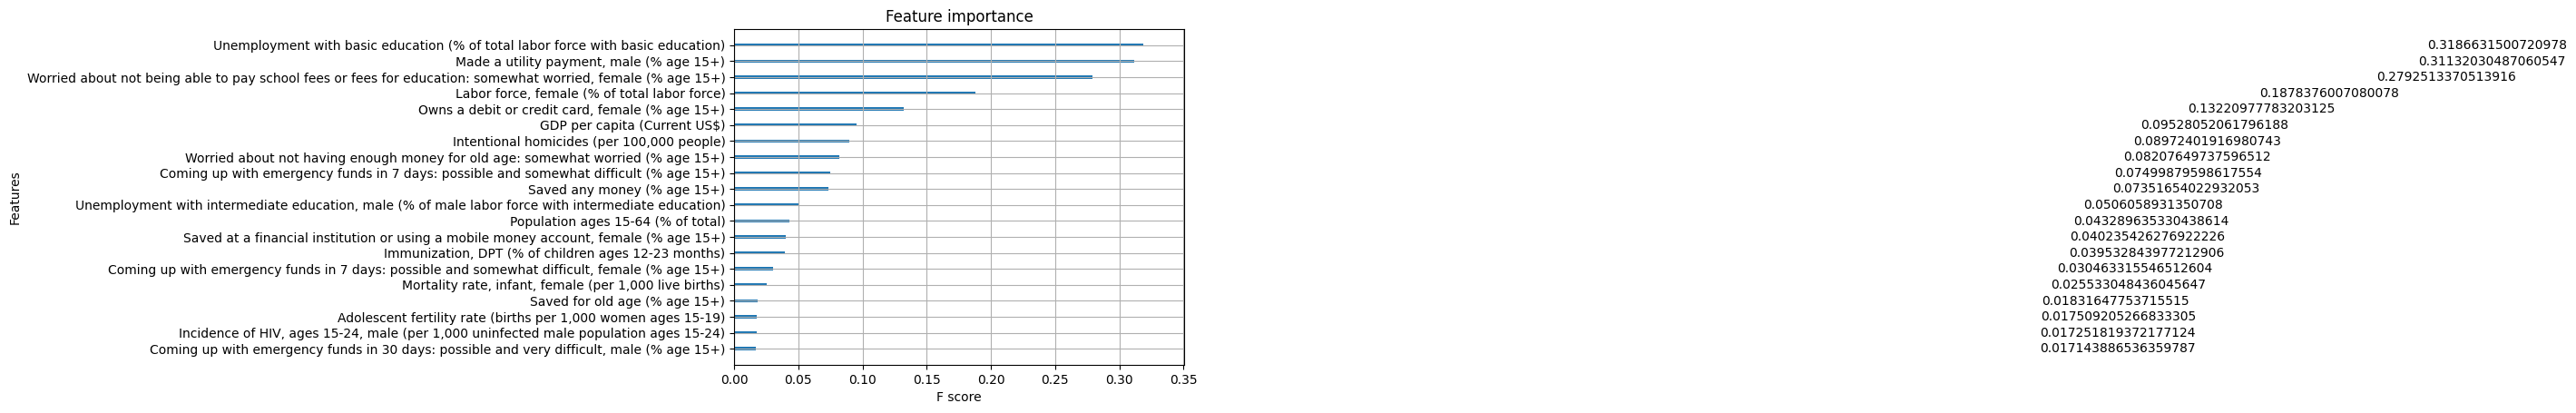

In [17]:
xgb.plot_importance(clf_xgb, max_num_features=20, importance_type='gain')

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


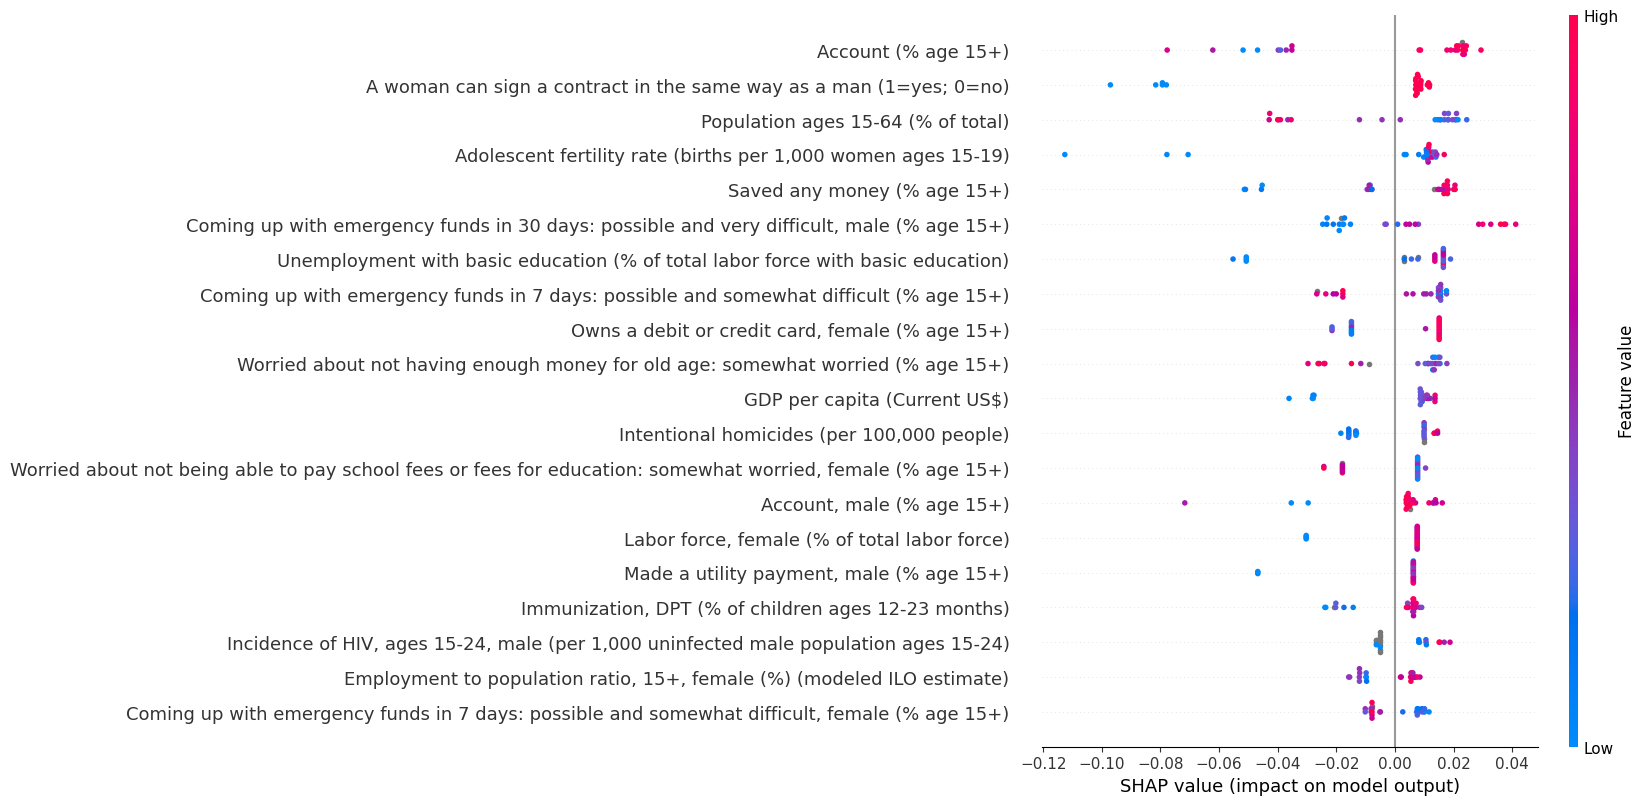

In [18]:
shap_values = shap.TreeExplainer(clf_xgb).shap_values(X)
shap.summary_plot(shap_values, X)

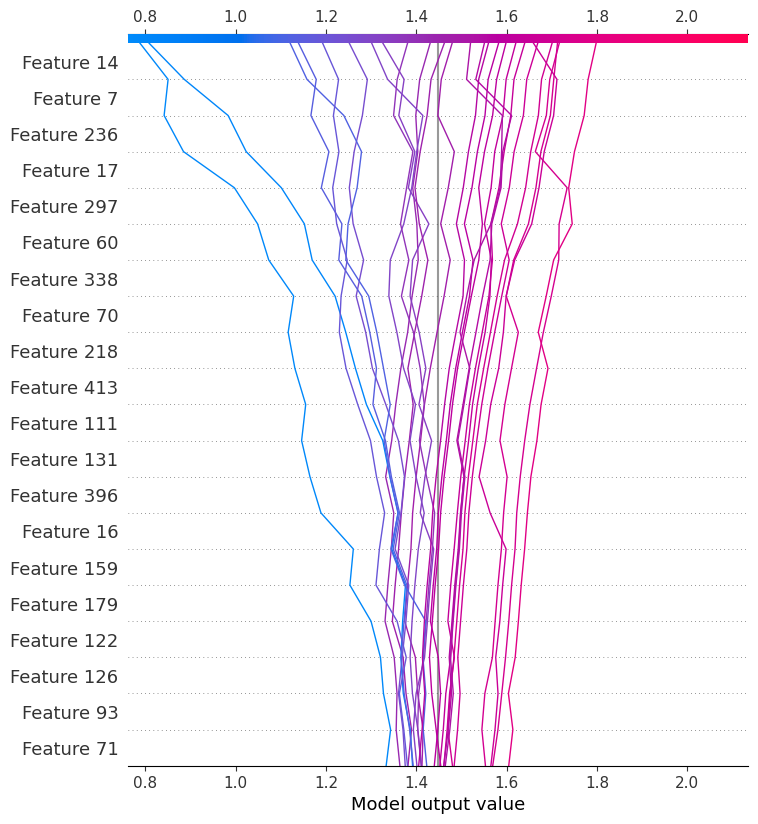

In [20]:
explainer = shap.TreeExplainer(clf_xgb)
expected_value = explainer.expected_value
shap.decision_plot(expected_value, shap_values)

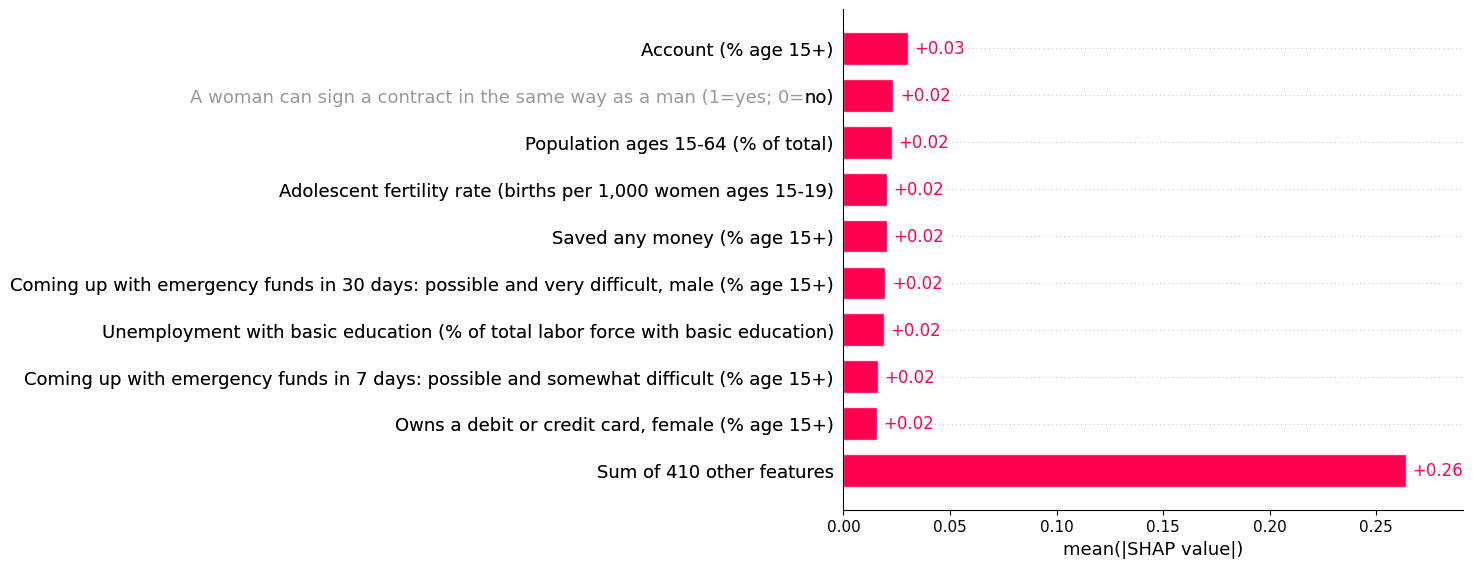

In [25]:
explainer = shap.Explainer(clf_xgb)
shap_values = explainer(X)
shap.plots.bar(shap_values)

In [26]:
shap.plots.force(shap_values[0:100])

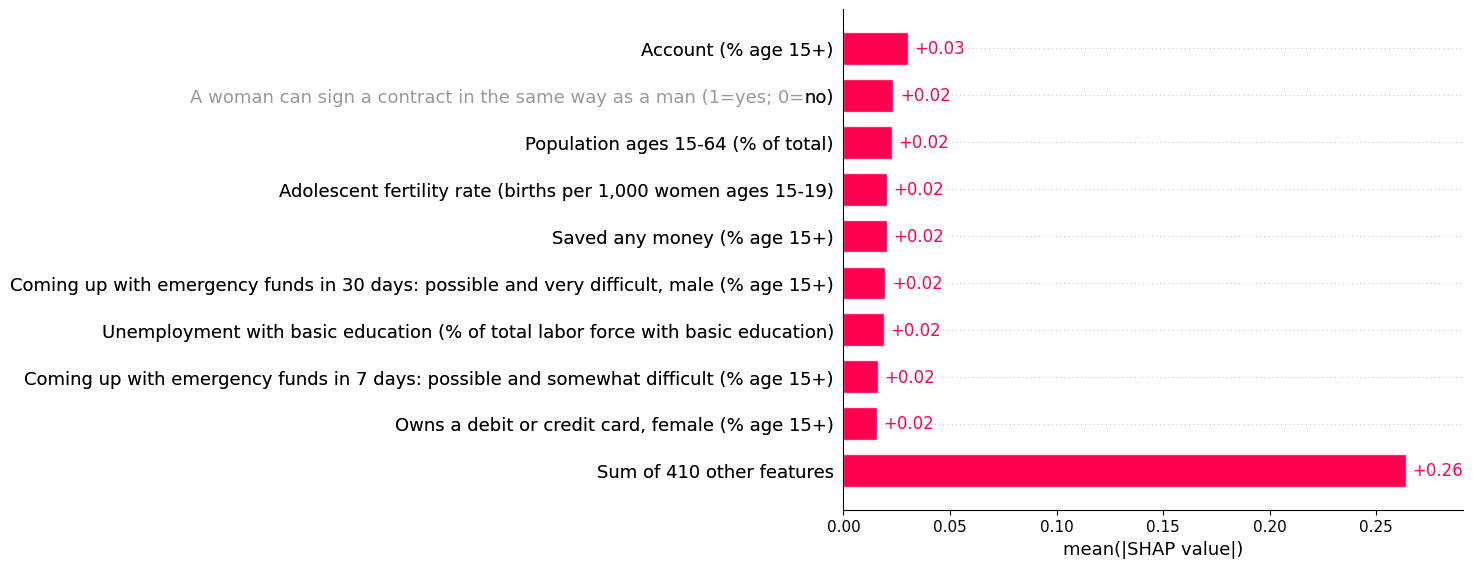

In [27]:
shap.plots.bar(shap_values)

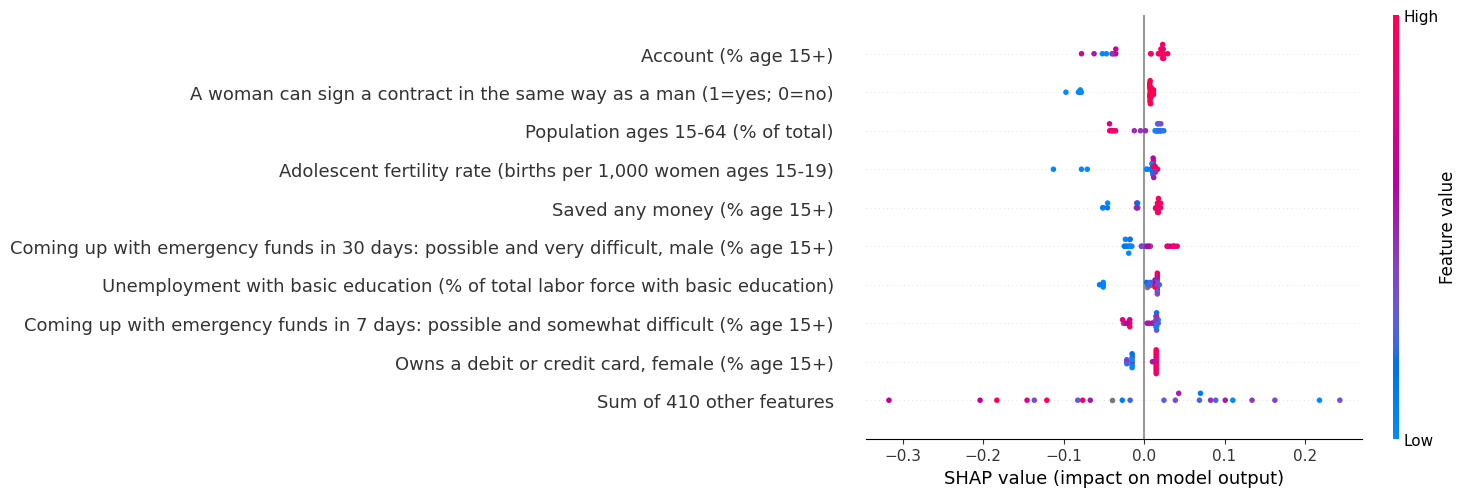

In [28]:
shap.plots.beeswarm(shap_values)